In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic

In [2]:
gpitch.amtgp.init_settings()
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

In [3]:
np.random.seed(3)
Nc = 3  # number of partials
var = np.random.rand(Nc)  # variances
leng = 10*np.random.rand(Nc)  # lengthscales
freq = 2000*np.random.rand()*np.asarray(range(1, Nc+ 1))  # frequencies
kern_com = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=leng, variances=var, frequencies=freq)
kern_act = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.075, variance=10.)

In [4]:
kern_com

Name,values,prior,constraint
unnamed.frequency_1,[ 251.17062093],None,+ve
unnamed.frequency_2,[ 502.34124186],None,+ve
unnamed.frequency_3,[ 753.51186278],None,+ve
unnamed.lengthscale_1,[ 5.10827605],None,+ve
unnamed.lengthscale_2,[ 8.92946954],None,+ve
unnamed.lengthscale_3,[ 8.96293089],None,+ve
unnamed.variance_1,[ 0.5507979],None,+ve
unnamed.variance_2,[ 0.70814782],None,+ve
unnamed.variance_3,[ 0.29090474],None,+ve


In [5]:
kern_act

Name,values,prior,constraint
unnamed.lengthscales,[ 0.075],None,+ve
unnamed.variance,[ 10.],None,+ve


In [6]:
N, fs = 1600, 16e3
x = np.linspace(0., (N-1.)/fs, N).reshape(-1, 1)
Kcom = kern_com.compute_K_symm(x)
Kact = kern_act.compute_K_symm(x)

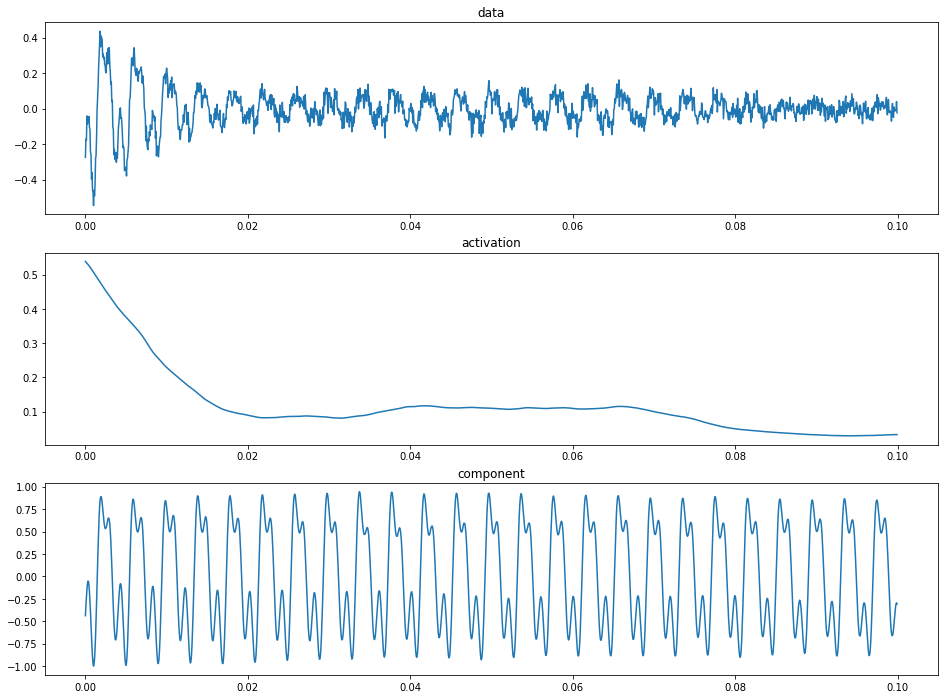

In [7]:
noise_var = 1e-3
com = np.random.multivariate_normal(np.zeros((N)), Kcom, 1).reshape(-1, 1)
com /= np.max(np.abs(com))
g = np.random.multivariate_normal(np.zeros((N)), Kact, 1).reshape(-1, 1)
act = logistic(g)
y = act*com + np.sqrt(noise_var)*np.random.randn(N,1)

plt.figure(figsize=(16, 12))
plt.subplot(3,1,1), plt.title('data')
plt.plot(x, y)
plt.subplot(3,1,2), plt.title('activation')
plt.plot(x, act)
plt.subplot(3,1,3), plt.title('component')
plt.plot(x, com)

In [8]:
ws, dec = N//1, 160  # samples per window, decimation factor
m = gpitch.modpdet.ModPDet(x=x, y=y, kern_com=kern_com, kern_act=kern_act, ws=ws, dec=dec, whiten=True)
m.model.kern1.fixed = True
m.model.kern2.fixed = False
m.model.likelihood.noise_var.fixed = False

In [9]:
maxiter, restarts = 1000, 5
init_hyper, learnt_hyper, mse = m.optimize_restart(maxiter=maxiter, restarts=restarts)

| len: 0.96695019, 0.12376652 | sig: 2.38231274, 11.83906625 | noise_var: 0.02192286, 0.00118621 |
| len: 0.66889670, 0.11728737 | sig: 3.88942729, 10.18542975 | noise_var: 0.08974194, 0.00118526 |
| len: 0.94782290, 0.12467213 | sig: 4.84601237, 12.12256298 | noise_var: 0.07860538, 0.00118509 |
| len: 0.53565525, 0.12773545 | sig: 13.29386482, 13.01653732 | noise_var: 0.04994534, 0.00118501 |
| len: 0.64588522, 0.12952728 | sig: 13.99275519, 13.60172379 | noise_var: 0.01488537, 0.00118520 |


In [10]:
m.model.kern2.lengthscales = learnt_hyper[0].mean().copy()
m.model.kern2.variance = learnt_hyper[1].mean().copy()
m.model.likelihood.noise_var = learnt_hyper[2].mean().copy()

In [11]:
m.model.kern2

Name,values,prior,constraint
kern2.lengthscales,[ 0.12459775],None,+ve
kern2.variance,[ 12.15306402],None,+ve


In [12]:
m.model.kern1

Name,values,prior,constraint
kern1.frequency_1,[ 251.17062093],None,[FIXED]
kern1.frequency_2,[ 502.34124186],None,[FIXED]
kern1.frequency_3,[ 753.51186278],None,[FIXED]
kern1.lengthscale_1,[ 5.10827605],None,[FIXED]
kern1.lengthscale_2,[ 8.92946954],None,[FIXED]
kern1.lengthscale_3,[ 8.96293089],None,[FIXED]
kern1.variance_1,[ 0.5507979],None,[FIXED]
kern1.variance_2,[ 0.70814782],None,[FIXED]
kern1.variance_3,[ 0.29090474],None,[FIXED]


In [13]:
print m.model.likelihood.noise_var

noise_var transform:[0.0, 0.1] prior:None
[ 0.00118536]


In [14]:
m.optimize_windowed(disp=1, maxiter=1000)

In [15]:
m.model.kern1

Name,values,prior,constraint
kern1.frequency_1,[ 251.17062093],None,[FIXED]
kern1.frequency_2,[ 502.34124186],None,[FIXED]
kern1.frequency_3,[ 753.51186278],None,[FIXED]
kern1.lengthscale_1,[ 5.10827605],None,[FIXED]
kern1.lengthscale_2,[ 8.92946954],None,[FIXED]
kern1.lengthscale_3,[ 8.96293089],None,[FIXED]
kern1.variance_1,[ 0.5507979],None,[FIXED]
kern1.variance_2,[ 0.70814782],None,[FIXED]
kern1.variance_3,[ 0.29090474],None,[FIXED]


In [16]:
m.model.kern2

Name,values,prior,constraint
kern2.lengthscales,[ 0.12423397],None,+ve
kern2.variance,[ 11.98046317],None,+ve


In [17]:
print m.model.likelihood.noise_var

noise_var transform:[0.0, 0.1] prior:None
[ 0.00118491]


In [18]:
mean_f, var_f = m.model.predict_f(x)
mean_g, var_g = m.model.predict_g(x)
mean_act = logistic(mean_g)

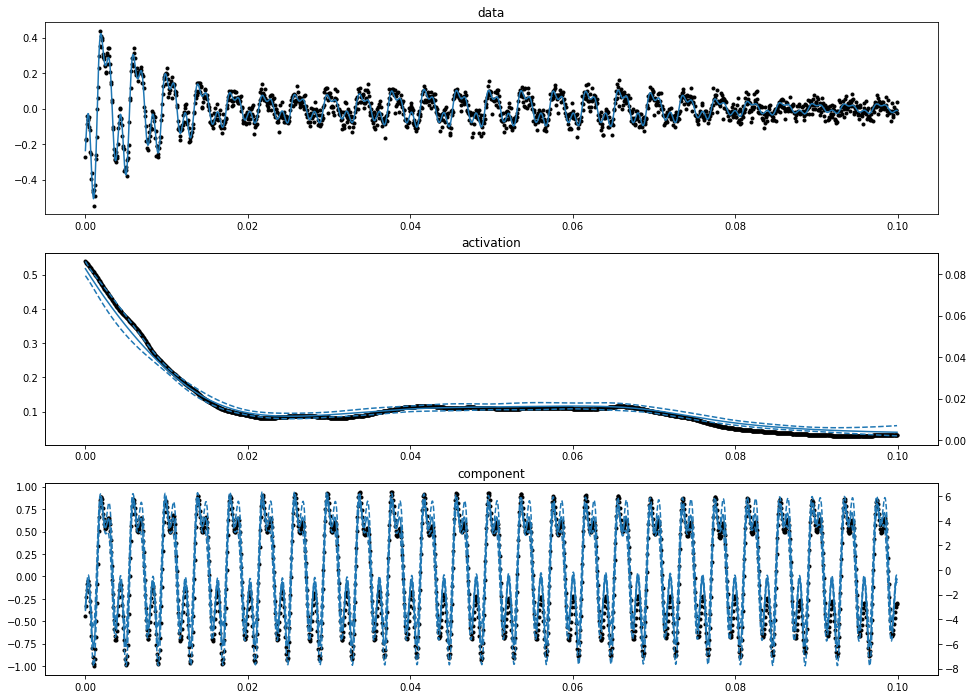

In [19]:
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plt.plot(x, y, '.k'), plt.title('data')
plt.plot(x, act*com)

plt.subplot(3,1,2)
plt.plot(x, act, '.k'), plt.title('activation')
plt.twinx()
plt.plot(x, mean_act)
plt.plot(x, logistic(mean_g + 2.*np.sqrt(var_g)), '--C0')
plt.plot(x, logistic(mean_g - 2.*np.sqrt(var_g)), '--C0')

plt.subplot(3,1,3)
plt.plot(x, com, '.k'), plt.title('component')
plt.twinx()
plt.plot(x, mean_f)
plt.plot(x, mean_f + 2.*np.sqrt(var_f), '--C0')
plt.plot(x, mean_f - 2.*np.sqrt(var_f), '--C0')